### Introduction
In this lab, you will need to implement simple EEG classification models with BCI competition dataset:
- EEGNet
- DeepConvNet

Also, you need to try different kinds of activation function:
- ReLU
- Leaky RelU
- ELU

#### Import libraries

In [1]:
import argparse
import torch
from BCIDataset import BCIDataset
from models.EEGNet import EEGNet
from models.DeepConvNet import DeepConvNet
from utils import *

args = {
    'batch_size': 64,
    'lr': 0.001,
    'num_epochs': 300,
}

#### Define training prodecure

In [2]:
def train(args, model, trainLoader, testLoader, loss_fn, optimizer, device):
    print('\n----- start training -----')
    train_acc, test_acc = [], []
    best_acc = 0.0
    for epoch in range(args["num_epochs"]):
        total_loss = 0
        total, correct = 0, 0
        model.train()
        for idx, (data, label) in enumerate(trainLoader):
            optimizer.zero_grad()
            data, label = data.to(device), label.to(device)
            output = model(data)

            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        train_acc.append(100 * correct / total)

        # Evaluation on testset
        with torch.no_grad():
            model.eval()
            total_test, correct_test = 0, 0
            for idx, (data, label) in enumerate(testLoader):
                data, label = data.to(device), label.to(device)
                output = model(data)

                _, predicted = torch.max(output.data, 1)
                total_test += label.size(0)
                correct_test += (predicted == label).sum().item()
            test_acc.append(100 * correct_test / total_test)

            if test_acc[-1] > best_acc:
                best_acc = test_acc[-1]

        # print('Epoch: [{}/{}] loss: {:.5f}, acc: {:.2f}%, test_acc: {:.2f}%'. \
        #     format(epoch+1, args["num_epochs"], total_loss / len(trainLoader), train_acc[-1], test_acc[-1]))
    print('-- Best acc: {:.2f}'.format(best_acc))

    return train_acc, test_acc

#### Create dataset and dataloader

In [3]:
torch.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using:', device)

trainset = BCIDataset(train=True)
testset = BCIDataset(train=False)

trainLoader = torch.utils.data.DataLoader(trainset, batch_size=args["batch_size"], shuffle=True)
testLoader = torch.utils.data.DataLoader(testset, batch_size=args["batch_size"], shuffle=True)

model_EEGNet = EEGNet().to(device)
model_DeepConvNet = DeepConvNet().to(device)
# print(model_EEGNet, '\n')
# print(model_DeepConvNet, '\n')

init_state_eeg = model_EEGNet.state_dict()
init_state_deep = model_DeepConvNet.state_dict()

loss_fn = torch.nn.CrossEntropyLoss()

Using: cuda:0


#### Evaluate for experiments result with 3 activation functions | EEGNet
- ELU
- ReLU
- LeakyReLU


----- start training -----
-- Best acc: 88.80

----- start training -----
-- Best acc: 88.06

----- start training -----
-- Best acc: 84.81


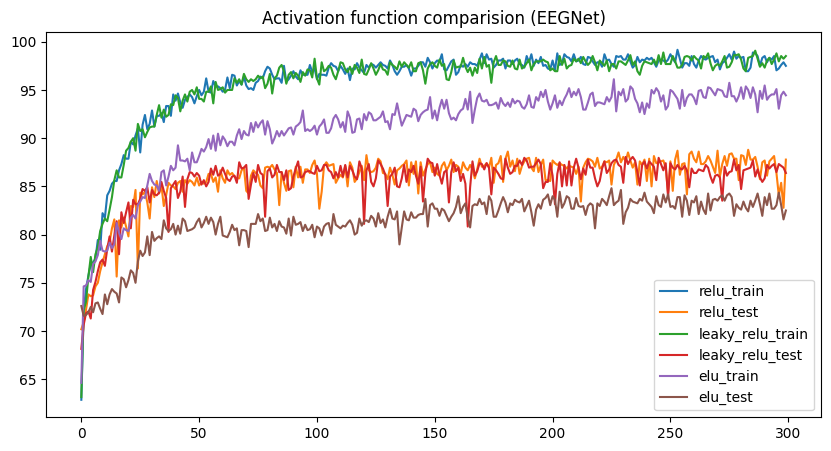

In [5]:
activations = ['relu', 'leakyRelu', 'elu']
train_result, test_result = [], []

for act in activations:
    model = EEGNet(activation=act).to(device)
    model.load_state_dict(init_state_eeg)
    optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"], weight_decay=5e-3)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-3)

    train_acc, test_acc = train(args, model, trainLoader, testLoader, loss_fn, optimizer, device)
    train_result.append(train_acc)
    test_result.append(test_acc)

show_result(args["num_epochs"], train_result, test_result, 'EEGNet')

#### Evaluate for experiments result with 3 activation functions | DeepConvNet
- ELU
- ReLU
- LeakyReLU


----- start training -----
-- Best acc: 85.28

----- start training -----
-- Best acc: 83.52

----- start training -----
-- Best acc: 81.48


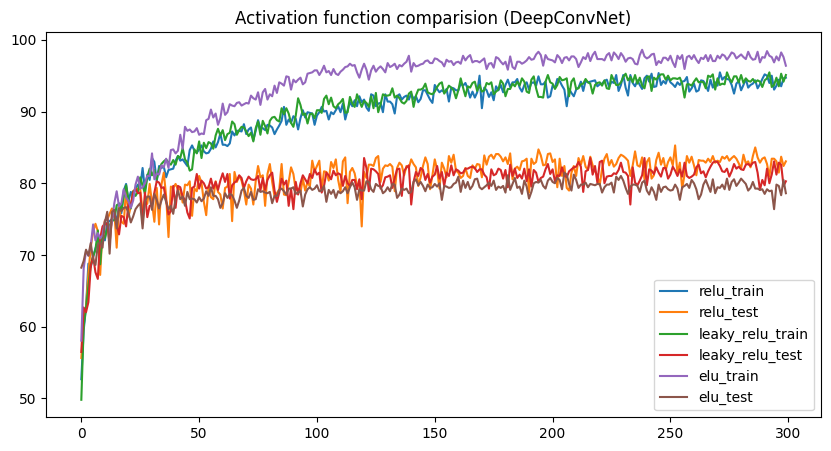

In [11]:
activations = ['relu', 'leakyRelu', 'elu']
train_result, test_result = [], []

for act in activations:
    model = DeepConvNet(activation=act).to(device)
    model.load_state_dict(init_state_deep)
    optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"], weight_decay=5e-3)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=5e-4)

    train_acc, test_acc = train(args, model, trainLoader, testLoader, loss_fn, optimizer, device)
    train_result.append(train_acc)
    test_result.append(test_acc)

show_result(args["num_epochs"], train_result, test_result, 'DeepConvNet')